## Multilabel Image Classification

### Problem Definition
- Training Multi-label Image Classifier using Deep Learning

### Dataset
- Dataset containing 4 labels with each having 0 and 1. `0` means label is absent, `1` is for present.
- Dataset contains few `unobserved labels`. Need to come up with the solution to fill these unobserved labels.
- Dataset is also `imbalanced`. Need to come up with the solution to handle the imbalance issue.

### Metrics
 
Below metrics will be calculate for each labels
- True Positive
- False Positive
- True Negative 
- False Negative
- Accuracy
- Prevalence
- Sensitivity
- Specificity
- PPV
- NPV
- AUC
- F1

threshold will also be shown for each of the label.

### Proposed Solution

The `unobserved/missing` labels will be filled by `Self-training`. In `Self-training`:
- I will split the dataset into TRAIN and TEST. TEST will be the datapoints where labels are missing.
- I will split the TRAIN dataset into further TRAIN and VAL (dev) split.
- I will Train the Deep Learning model and this model will be used to get the missing label.

There are many ways to handle the imbalance in the model.
1. Weighting the class means giving more weight to undersample class.
2. Oversampling/Undersampling the dataset.
3. Using LearningRateScheduler
4. Using augmentation techniques might help in case of images.

To TRAIN the DL models
- I will do fine-tuning with pretrained VGG Model (with `imagenet` weight).

### 1. Importing necessary libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import shutil, os, time, random, copy
import imageio.v2 as imageio
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, 
                             roc_curve, 
                             f1_score, 
                             precision_recall_curve, 
                             confusion_matrix, 
                             average_precision_score
                            )


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19 # importing VGG19 model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [9]:
!ls

__notebook_source__.ipynb  dataset  model_save	results  state.db


### 2. Loading dataset

In [10]:
input_dir = Path("/kaggle/input")
dataset_dir = input_dir/"multilabel-images"
img_dir = dataset_dir/"images"

In [11]:
labels_dataset = pd.read_csv(open(dataset_dir/"labels.txt","rb"), header=None, names=["filename","l1","l2","l3","l4"], sep=" ")
labels_dataset.head()

,filename,l1,l2,l3,l4
0,image_0.jpg,1.0,NaN,0.0,1.0
1,image_1.jpg,NaN,0.0,0.0,0.0
2,image_2.jpg,1.0,1.0,0.0,0.0
3,image_3.jpg,1.0,1.0,0.0,0.0
4,image_4.jpg,1.0,1.0,0.0,0.0


In [12]:
print(f"No.of datapoints: {labels_dataset.shape[0]}")

No.of datapoints: 975


#### There are few files which are not present in the image directory. So, removing those rows

`image_489.jpg`, `image_624.jpg`, `image_875.jpg` is not present in the `image/` directory

In [13]:
# find image names which doesn't exist
to_exclude_filenames = []
for l in labels_dataset.filename:
    if not Path(f"{img_dir}/{l}").exists():
        to_exclude_filenames.append(l)
        

In [14]:
to_exclude_filenames

['image_489.jpg', 'image_624.jpg', 'image_875.jpg']

In [15]:
labels_dataset = labels_dataset.loc[~labels_dataset["filename"].isin(to_exclude_filenames)]
labels_dataset.reset_index(inplace=True)
labels_dataset.shape

(972, 6)

#### 2.1 No.of datapoints where there is unobserved observation(missing labels or NaN) in any column/label

In [16]:
labels_dataset.isna().sum()
# there is no difference between isna() and isnull()
# link for ref: https://www.skytowner.com/explore/difference_between_dataframeisna_and_dataframeisnull_#:~:text=Difference%20between%20DataFrame.-,isna()%20and,isnull()&text=There%20is%20absolutely%20no%20difference,for%20missing%20values%20(%20NaN%20).

index        0
filename     0
l1          80
l2          91
l3          92
l4          92
dtype: int64

__2.1.Summary: Labels are containing NaN values. I will have to look into it to fill the NaN value.__

- I will use <b>Self-training</b> to fill the NaN values

#### 2.2 distribution of labels

In [17]:
# distributions of labels
labels_dataset.l1.value_counts()

1.0    786
0.0    106
Name: l1, dtype: int64

In [18]:
labels_dataset.l2.value_counts()

1.0    710
0.0    171
Name: l2, dtype: int64

In [19]:
labels_dataset.l3.value_counts()

1.0    464
0.0    416
Name: l3, dtype: int64

In [20]:
labels_dataset.l4.value_counts()

0.0    812
1.0     68
Name: l4, dtype: int64

__2.2.Summary of labels distributions:__
- except `l3`, all of them are highly imbalanced.


#### 2.2. Calculating the image dimension

In [21]:
count=0
width = []
height = []
from tqdm import tqdm
for image in tqdm(img_dir.iterdir()):
    # print(image)
    img = load_img(image)
    w,h=img.size
    width.append(w)
    height.append(h)

W = int(np.mean(width))
H= int(np.mean(height))
W,H

972it [00:00, 1388.92it/s]


(736, 879)

In [22]:
# Mean Width and Height is 736, 879
# But I will half of this
W, H = 350, 450 

## 3. Handling missing labels

- One way to handle missing labels is train models on labeled data and do the prediction on unlabeled dataset and then finall train the model on complete dataset. This is also known as `Self-Training`

### 3.1. Training CNN models for label `l1`, `l2`, `l3`, `l4`
In this section I will train (fine-tune) pretrained VGG19 model on the dataset for label `l1`, `l2`, `l3`, `l4`

#### 3.1.1. Creating dataset for label `l1`, `l2`, `l3`, `l4`

__NOTE:__ I will just change the column name and will fill the NaN for each labels

In [23]:
# creating dataset
column = "l4"
dataset = labels_dataset[['filename',column]]
dataset.head()

,filename,l4
0,image_0.jpg,1.0
1,image_1.jpg,0.0
2,image_2.jpg,0.0
3,image_3.jpg,0.0
4,image_4.jpg,0.0


In [24]:
# Now held out the NaN for labeling (as a test dataset)
test = dataset[dataset[column].isnull()].copy()
# test[column] = test[column].astype(int).astype(str)
test.head()

,filename,l4
5,image_5.jpg,NaN
18,image_18.jpg,NaN
38,image_38.jpg,NaN
39,image_39.jpg,NaN
44,image_44.jpg,NaN


In [25]:
print(f"No.of datpoints to be labeled: {test.shape[0]}")

No.of datpoints to be labeled: 92


In [26]:
# Filter the training datapoints from the label1_df (where value is not NaN)
train = dataset[dataset[column].notnull()].copy()
train.head()

,filename,l4
0,image_0.jpg,1.0
1,image_1.jpg,0.0
2,image_2.jpg,0.0
3,image_3.jpg,0.0
4,image_4.jpg,0.0


In [27]:
print(f"No.of datapoints in training set: {train.shape[0]} ")

No.of datapoints in training set: 880 


In [28]:
print(f"label distribution for {column}: \n{train[column].value_counts()} ")

label distribution for l4: 
0.0    812
1.0     68
Name: l4, dtype: int64 


#### 3.1.1.Summary
- Dataset is imbalanced. So, we can apply class_weight or upsampling the dataset

__TRICKS__
1. Re-Weighting
2. Learning Rate Scheduler
3. Data Augmentation and Resampling (Undersampling and Oversampling)
4. Label Smooting (generally used for more than 100 classes). We will not use here
5. Change Loss Function
    - Generally Focal loss is used for imbalanced dataset
    


There are a few techniques to be used:
- Data Augmentation in case of Image data will help.
- We can also do upsampling but It might lead to the model overfitted towards the upsampled class.  (can try it and see th result)
- Using right metric to judge the model like `Precision`, `Recall`, `f1-score` with the `threshold`.
- To train `CNN` model on this dataset, I will `class_weight` because of this imbalanced. And can use `Weighted Loss` also.

#### 3.1.2. Getting class weight using sklearn

In [29]:
from sklearn.utils.class_weight import compute_class_weight
weight = compute_class_weight(class_weight="balanced",y=train[column], classes=train[column].unique())
class_weight = dict(zip(list(map(int, train[column].unique())),weight))
class_weight

{1: 6.470588235294118, 0: 0.541871921182266}

NOTE: The images are of different shape

- So, we will use resize of the image with height greater than width like 1280x1000(h,w)

#### 3.1.3. See the sample images to each class

In [30]:
dataset_dir

PosixPath('/kaggle/input/multilabel-images')

Below images belongs to class 0
/kaggle/input/multilabel-images/images/image_1.jpg


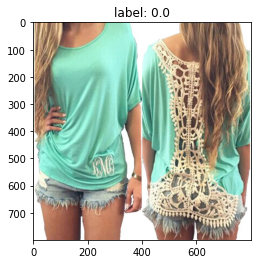

/kaggle/input/multilabel-images/images/image_2.jpg


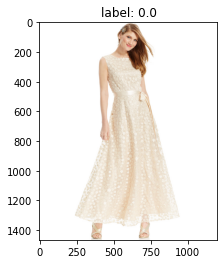

/kaggle/input/multilabel-images/images/image_3.jpg


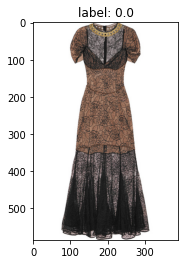

/kaggle/input/multilabel-images/images/image_4.jpg


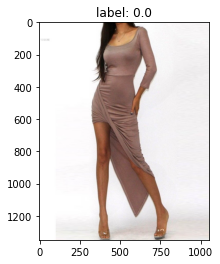

/kaggle/input/multilabel-images/images/image_6.jpg


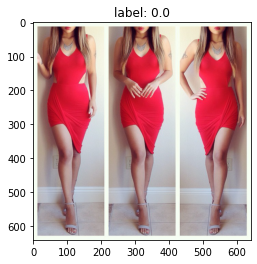

/kaggle/input/multilabel-images/images/image_7.jpg


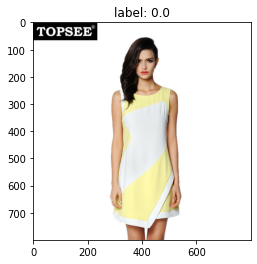

--------------------------------------------------
Below images belongs to class 1
/kaggle/input/multilabel-images/images/image_0.jpg


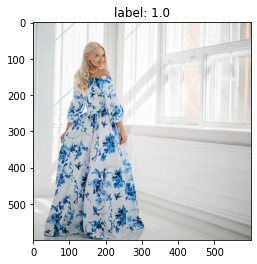

/kaggle/input/multilabel-images/images/image_24.jpg


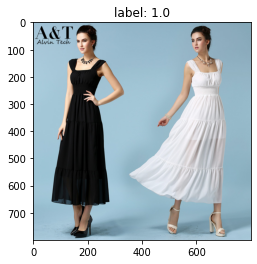

/kaggle/input/multilabel-images/images/image_27.jpg


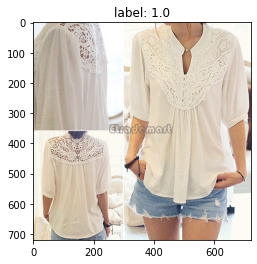

/kaggle/input/multilabel-images/images/image_33.jpg


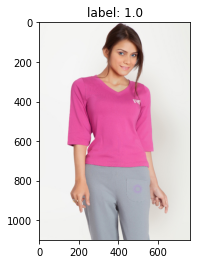

/kaggle/input/multilabel-images/images/image_46.jpg


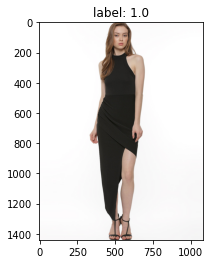

/kaggle/input/multilabel-images/images/image_48.jpg


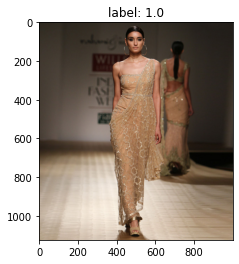

In [31]:
count = 0
MAX = 5
train_labels = train[column].unique()
img_dir = dataset_dir/"images"

print(f"Below images belongs to class 0")
for index in train.index:
    label = train[column].loc[index]
    image_name = train['filename'].loc[index]
    if count<=MAX and label==0.0:
        # read image
        img_path = f"{img_dir}/{image_name}"
        img = load_img(img_path)
        print(img_path)
        plt.imshow(img)
        plt.title(f"label: {label}")
        plt.show()
        count+=1
        
print("-"*50)
print(f"Below images belongs to class 1")
count=0
for index in train.index:
    label = train[column].loc[index]
    image_name = train['filename'].loc[index]
    if count<=MAX and label==1.0:
        # read image
        img_path = f"{img_dir}/{image_name}"
        img = load_img(img_path)
        print(img_path)
        plt.imshow(img)
        plt.title(f"label: {label}")
        plt.show()
        count+=1

#### 3.1.4 Creating a Data Generator with Augmentations

In [32]:
# update the column type to string
train[column] = train[column].astype(int).astype(str)

In [33]:
# Image data generator
# ref: https://stackoverflow.com/questions/62484597/understanding-width-shift-range-and-height-shift-range-arguments-in-kerass
# ref: https://stackoverflow.com/questions/57301330/what-exactly-the-shear-do-in-imagedatagenerator-of-keras#:~:text='Shear'%20means%20that%20the%20image,see%20things%20from%20different%20angles.
import tensorflow as tf
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8,1.0),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest", # can use constant also
#     validation_split=0.2, # 20% of the data will be splitted for validation split
)

# I don't want to use Augmentation on validation dataset
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

##### 3.1.4.a. let's see how the augmentation will look like

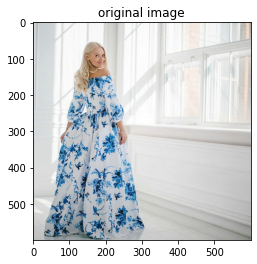

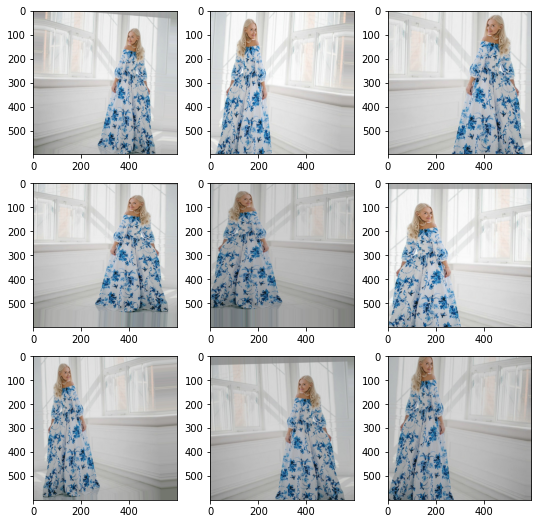

In [34]:
# load the image
img_path = img_dir/'image_0.jpg'
img = load_img(img_path)
plt.imshow(img)
plt.title("original image")
plt.show()
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
# # create image data augmentation generator
# datagen = ImageDataGenerator(height_shift_range=0.5)
# prepare iterator
it = training_datagen.flow(samples, batch_size=1)

# generate samples and plot
rows, cols = 3, 3
plt.figure(figsize=(rows*3,cols*3))

for i in range(rows*cols):
	# define subplot
	plt.subplot(rows,cols,1+i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0]
	# plot raw pixel data
	plt.imshow(image)

# show the figure
plt.show()

#### 3.1.5 Oversample the dataset

- It should also be tried in place of weighting the class.

In [35]:
train[column].value_counts()

0    812
1     68
Name: l4, dtype: int64

In [36]:
powercount = {}
# getting labels in the 'l1'
labels = train[column].unique()

# getting the maxcount 
for l in labels:
    powercount[l] = np.count_nonzero(train[column]==l)
maxcount = np.max(list(powercount.values()))

# oversample the label which are less
# for each label  in labels
data_df = train.copy()
for l in labels:
    gapnum = maxcount - powercount[l]
    print(gapnum)
    temp_df = train.iloc[np.random.choice(np.where(train[column]==l)[0], size=gapnum)]
    data_df = data_df.append(temp_df, ignore_index=True)

train = train.sample(frac=1).reset_index(drop=True)

744
0


In [37]:
train[column].value_counts()

0    812
1     68
Name: l4, dtype: int64

In [38]:
temp_df[column].value_counts()

Series([], Name: l4, dtype: int64)

In [39]:
data_df[column].value_counts()

1    812
0    812
Name: l4, dtype: int64

#### 3.1.6 Getting TRAIN and VAL dataset

In [40]:
train_df, validation_df = train_test_split(data_df, test_size=0.2, stratify=data_df[column], random_state=42,)
train_df[column].value_counts(), validation_df[column].value_counts()

(1    650
 0    649
 Name: l4, dtype: int64,
 0    163
 1    162
 Name: l4, dtype: int64)

In [41]:
train_dataset = training_datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col = "filename",
    y_col = column,
    directory=img_dir,
    target_size = (H,W),
    seed=42,
    batch_size=32, # use small batch size to overcome memory warning,
    class_mode="binary", # sparse for multilabel
    shuffle=True,
)

Found 1299 validated image filenames belonging to 2 classes.


In [42]:
pd.Series(train_dataset.classes).value_counts()

1    650
0    649
dtype: int64

In [43]:
validation_dataset = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col = 'filename',
    y_col = column,
    directory=img_dir,
    target_size = (H,W),
    seed=42,
    batch_size=32, # use small batch size to overcome memory warning,
    class_mode="binary", # sparse for multilabel
    shuffle=True,
)

Found 325 validated image filenames belonging to 2 classes.


In [44]:
pd.Series(validation_dataset.classes).value_counts()

0    163
1    162
dtype: int64

#### 3.1.7. Creating callbacks Callbacks

In [45]:
# adaptive learning rate scheduler to handle imbalance
# credit: https://www.linkedin.com/pulse/some-tricks-handling-imbalanced-dataset-image-m-farhan-tandia
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """
    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):
        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type
        
    def on_epoch_begin(self, epoch, logs=None):
        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type] 
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]
            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple
            else:
                print(' '.join(('Learning rate:', str(current_lr))))
            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)
        else:
            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
            
        return tf.keras.backend.get_value(self.model.optimizer.lr)


callback_lr = LossLearningRateScheduler(base_lr=0.00001, lookback_epochs=2, loss_type='val_loss')

In [46]:
# save model if auc is improved
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = f"./model_save/best_{column}_model.hdf5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_auc',
    verbose=1, # tracking progress bar
    save_best_only=True,
    mode='max',
)

# early stop
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5, # wait for 5 epochs before stopping
)

callback_list = [
    checkpoint, 
    earlystop, 
    callback_lr
]

#### 3.1.8 Creating the Model

In [47]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'), 
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'), # specificity
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# sensitivity --> True Positive Rate --> TP/(TP+FN)
# specificity --> True Negative Rate --> TN /(TN+FP)

In [48]:
H,W

(450, 350)

In [49]:
fine_tuning=False
# clear all previous sessions
tf.keras.backend.clear_session()

def get_compiled_vgg_model():
    model = tf.keras.models.Sequential()
    vgg = tf.keras.applications.VGG19(
        include_top=False, 
        pooling='None',
        weights='imagenet',
        input_shape=(H,W,3),
    )
#     print(vgg.summary())
    # print(resnet.summary())
    model.add(vgg)
    model.add(
        tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=(3,3),
            strides=(1,1),
            padding="valid",
            data_format="channels_last",
            activation="relu",
            kernel_initializer=tf.keras.initializers.he_normal(seed=0),
            name="Conv1"
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=(3,3),
            strides=(2,2),
            padding="valid",
            data_format="channels_last",
            activation="relu",
            kernel_initializer=tf.keras.initializers.he_normal(seed=0),
            name="Conv2"
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=(5,3),
            strides=(1,1),
            padding="valid",
            data_format="channels_last",
            activation="relu",
            kernel_initializer=tf.keras.initializers.he_normal(seed=0),
            name="Conv3"
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=(1,1),
            padding="valid",
            data_format="channels_last",
            activation="relu",
            kernel_initializer=tf.keras.initializers.he_normal(seed=0),
            name="Conv4"
        )
    )
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))
    
    if fine_tuning:
        model.layers[0].trainable=True
    else:
        model.layers[0].trainable=False


    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=METRICS
    )
    return model

In [50]:
model = get_compiled_vgg_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 14, 10, 512)       20024384  
_________________________________________________________________
Conv1 (Conv2D)               (None, 12, 8, 256)        1179904   
_________________________________________________________________
Conv2 (Conv2D)               (None, 5, 3, 256)         590080    
_________________________________________________________________
Conv3 (Conv2D)               (None, 1, 1, 128)         491648    
_________________________________________________________________
Conv4 (Conv2D)               (None, 1, 1, 128)         16512     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

__Trainable params are 3.4M__

#### 3.1.9 Training the model

In [47]:
class_weight

{1: 6.470588235294118, 0: 0.541871921182266}

In [51]:
train=False
if train is True:
    model_history = model.fit(
        train_dataset, 
        epochs=40,
        verbose=1,
        validation_data=validation_dataset,
        shuffle=True,
#         class_weight=class_weight,
        callbacks=callback_list,
    )

#### 3.1.10 Plot the learning curve


In [52]:
# loading the best model
best_model_path=Path(f"./model_save/best_{column}_model.hdf5")
best_model = tf.keras.models.load_model(best_model_path)

In [53]:
results_dir = Path("./results")
if not results_dir.exists():
    results_dir.mkdir()
def plot_learning_curve(history, model_name="best_model"):
    
    # get the metric list
    metric_list = [key for key in history.keys() if 'val' not in key]
    
    for metric in metric_list:
        train = history[metric]
        val = history[f'val_{metric}']

        plt.figure(figsize=(13,5))
        plt.plot(train, label=f"TRAIN_{metric.upper()}")
        plt.plot(val, label=f"VAL_{metric.upper()}")
        plt.legend()
        plt.grid()
        plt.xlabel("Epochs")
        plt.ylabel(f"{metric.upper()}")
        plt.title(f"Train v/s Validation {metric.upper()} of {model_name}")
        plt.savefig(f"{results_dir}/{metric}_{model_name}.png")
        plt.show()

    
# plot_learning_curve(model_history.history, model_name=best_model_path.stem)

#### 3.1.11 Update the labels for the current column

In [54]:
multilabel_dataset_path = Path("/kaggle/working/dataset/multilabel_dataset.csv")
if multilabel_dataset_path.exists():
    labels_dataset = pd.read_csv(multilabel_dataset_path)

In [55]:
# header of test data
test.head()

,filename,l4
5,image_5.jpg,NaN
18,image_18.jpg,NaN
38,image_38.jpg,NaN
39,image_39.jpg,NaN
44,image_44.jpg,NaN


In [56]:
# for creating a data generator, column should be string not NaN
test[column] = test[column].apply(lambda x: str(x))

# create test data generator
test_dataset = validation_datagen.flow_from_dataframe(
    dataframe = test,
    x_col = 'filename',
    y_col = column,
    directory=img_dir,
    target_size = (H,W),
    seed=42,
    batch_size=32, # use small batch size to overcome memory warning,
    class_mode="sparse", # (hack) used sparse
    shuffle=False,
)

predictions = best_model.predict(test_dataset)
predictions = predictions.flatten()
predictions = pd.Series(index=test.index,data=predictions).apply(lambda x: 1.0 if x>0.5 else 0.0)

Found 92 validated image filenames belonging to 1 classes.


2022-11-29 19:04:05.506609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-29 19:04:06.543479: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [57]:
test[column] = predictions
test.head(90)

,filename,l4
5,image_5.jpg,0.0
18,image_18.jpg,1.0
38,image_38.jpg,0.0
39,image_39.jpg,1.0
44,image_44.jpg,0.0
...,...,...
890,image_893.jpg,0.0
920,image_923.jpg,1.0
936,image_939.jpg,0.0
938,image_941.jpg,0.0


In [58]:
test[column].value_counts()

0.0    69
1.0    23
Name: l4, dtype: int64

In [59]:
test_indices = test.index
labels_dataset[:].iloc[test_indices].head()

,index,filename,l1,l2,l3,l4
5,5,image_5.jpg,1.0,0.0,1.0,0.0
18,18,image_18.jpg,1.0,1.0,1.0,1.0
38,38,image_38.jpg,1.0,0.0,0.0,0.0
39,39,image_39.jpg,1.0,1.0,0.0,1.0
44,44,image_44.jpg,1.0,1.0,1.0,0.0


In [60]:
# update the original dataset
labels_dataset[column].iloc[test_indices] = predictions
labels_dataset.head(20)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,filename,l1,l2,l3,l4
0,0,image_0.jpg,1.0,1.0,0.0,1.0
1,1,image_1.jpg,1.0,0.0,0.0,0.0
2,2,image_2.jpg,1.0,1.0,0.0,0.0
3,3,image_3.jpg,1.0,1.0,0.0,0.0
4,4,image_4.jpg,1.0,1.0,0.0,0.0
5,5,image_5.jpg,1.0,0.0,1.0,0.0
6,6,image_6.jpg,1.0,1.0,0.0,0.0
7,7,image_7.jpg,1.0,1.0,1.0,0.0
8,8,image_8.jpg,1.0,1.0,1.0,0.0
9,9,image_9.jpg,1.0,0.0,1.0,0.0


In [61]:
dataset_dir_working = Path("./dataset")
if not dataset_dir.exists():
    dataset_dir.mkdir()
    
# save the preprocessed label dataset
labels_dataset.to_csv(dataset_dir_working/"multilabel_dataset.csv", index=False)

## Train Multi-label Image Classification model on labels_dataset containing no NaN values

### 1. Load dataset

In [62]:
dataset_dir = Path("./dataset")
multilabel_dataset = pd.read_csv(dataset_dir/"multilabel_dataset.csv")
multilabel_dataset.head()

,index,filename,l1,l2,l3,l4
0,0,image_0.jpg,1.0,1.0,0.0,1.0
1,1,image_1.jpg,1.0,0.0,0.0,0.0
2,2,image_2.jpg,1.0,1.0,0.0,0.0
3,3,image_3.jpg,1.0,1.0,0.0,0.0
4,4,image_4.jpg,1.0,1.0,0.0,0.0


In [63]:
multilabel_dataset.head()

,index,filename,l1,l2,l3,l4
0,0,image_0.jpg,1.0,1.0,0.0,1.0
1,1,image_1.jpg,1.0,0.0,0.0,0.0
2,2,image_2.jpg,1.0,1.0,0.0,0.0
3,3,image_3.jpg,1.0,1.0,0.0,0.0
4,4,image_4.jpg,1.0,1.0,0.0,0.0


#### 1.1 label distributions

In [64]:
multilabel_dataset.l1.value_counts()

1.0    848
0.0    124
Name: l1, dtype: int64

In [65]:
multilabel_dataset.l2.value_counts()

1.0    742
0.0    230
Name: l2, dtype: int64

In [66]:
multilabel_dataset.l3.value_counts()

1.0    495
0.0    477
Name: l3, dtype: int64

In [67]:
multilabel_dataset.l4.value_counts()

0.0    881
1.0     91
Name: l4, dtype: int64

#### 1.2. Create a power label to upsample the dataset

In [68]:
target_cols = ['l1','l2','l3','l4']
''.join(list(map(lambda x: str(int(x)),list(multilabel_dataset[target_cols].iloc[0]))))

'1101'

In [69]:
powerlabels = []
target_cols = ['l1','l2','l3','l4']
for i in range(multilabel_dataset.shape[0]):
    powerlabels.append(''.join(list(map(lambda x: str(int(x)),list(multilabel_dataset[target_cols].iloc[i])))))



In [70]:
multilabel_dataset['powerlabel'] = pd.Series(powerlabels)

#### 1.3 distribution of the labels

In [71]:
multilabel_dataset.powerlabel.value_counts()

1110    303
1100    280
1000     99
1010     88
0110     49
0100     42
1101     30
1111     29
0000     10
1001     10
0010     10
1011      9
0101      5
0111      4
0011      3
0001      1
Name: powerlabel, dtype: int64

#### 1.4 Upsample the dataset

In [72]:
powercount = {}
# getting labels in the 'powerlabel'
column='powerlabel'
powerlabels = multilabel_dataset[column].unique()

# getting the maxcount 
for l in powerlabels:
    powercount[l] = np.count_nonzero(multilabel_dataset[column]==l)
maxcount = np.max(list(powercount.values()))

# oversample the label which are less
# for each label  in labels
multilabel_balanced = multilabel_dataset.copy()
for l in powerlabels:
    gapnum = maxcount - powercount[l]
    print(gapnum)
    temp_df = multilabel_dataset.iloc[np.random.choice(np.where(multilabel_dataset[column]==l)[0], size=gapnum)]
    multilabel_balanced = multilabel_balanced.append(temp_df, ignore_index=True)

multilabel_dataset = multilabel_dataset.sample(frac=1).reset_index(drop=True)

273
204
23
215
0
293
274
261
293
298
293
294
254
299
300
302


In [73]:
multilabel_dataset.powerlabel.value_counts()

1110    303
1100    280
1000     99
1010     88
0110     49
0100     42
1101     30
1111     29
1001     10
0010     10
0000     10
1011      9
0101      5
0111      4
0011      3
0001      1
Name: powerlabel, dtype: int64

In [74]:
multilabel_balanced.powerlabel.value_counts()

1101    303
1000    303
1100    303
1010    303
1110    303
0000    303
1111    303
0100    303
1001    303
0101    303
0010    303
1011    303
0110    303
0111    303
0011    303
0001    303
Name: powerlabel, dtype: int64

#### Summary:
- Powerlabel is balanced but will have to check the individual label imbalance

In [75]:
multilabel_balanced.l1.value_counts()

1.0    2424
0.0    2424
Name: l1, dtype: int64

In [76]:
multilabel_balanced.l2.value_counts()

1.0    2424
0.0    2424
Name: l2, dtype: int64

In [77]:
multilabel_balanced.l3.value_counts()

0.0    2424
1.0    2424
Name: l3, dtype: int64

In [78]:
multilabel_balanced.l4.value_counts()

1.0    2424
0.0    2424
Name: l4, dtype: int64

### 2. Train CNN for Multi-label Image Classification

#### 2.1 Split the datset into train and validation

In [79]:
train_df, val_df = train_test_split(multilabel_balanced, test_size=0.2, random_state=42, stratify=multilabel_balanced.l1)


In [80]:
train_df.l1.value_counts(), val_df.l1.value_counts()

(1.0    1939
 0.0    1939
 Name: l1, dtype: int64,
 0.0    485
 1.0    485
 Name: l1, dtype: int64)

#### 2.2 Creating Data Generator

In [81]:
# Image data generator
# ref: https://stackoverflow.com/questions/62484597/understanding-width-shift-range-and-height-shift-range-arguments-in-kerass
# ref: https://stackoverflow.com/questions/57301330/what-exactly-the-shear-do-in-imagedatagenerator-of-keras#:~:text='Shear'%20means%20that%20the%20image,see%20things%20from%20different%20angles.
import tensorflow as tf
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8,1.0),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest", # can use constant also
#     validation_split=0.2, # 20% of the data will be splitted for validation split
)

# I don't want to use Augmentation on validation dataset
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

In [82]:
target_cols

['l1', 'l2', 'l3', 'l4']

In [83]:
train_dataset = training_datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col = "filename",
    y_col = target_cols,
    directory=img_dir,
    target_size = (H,W),
    seed=42,
    batch_size=8, # use small batch size to overcome memory warning,
    class_mode="raw",
    shuffle=True,
)

Found 3878 validated image filenames.


In [84]:
validation_dataset = validation_datagen.flow_from_dataframe(
    dataframe= val_df,
    x_col = "filename",
    y_col = target_cols,
    directory=img_dir,
    target_size = (H,W),
    seed=42,
    batch_size=8, # use small batch size to overcome memory warning,
    class_mode="raw",
    shuffle=True,
)

Found 970 validated image filenames.


#### 2.3 Creating callbacks


In [85]:
callback_lr = LossLearningRateScheduler(base_lr=0.00001, lookback_epochs=2, loss_type='val_loss')

# save model if auc is improved
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = f"./model_save/best_multilabel_model.hdf5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_auc',
    verbose=1, # tracking progress bar
    save_best_only=True,
    mode='max',
)

# early stop
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5, # wait for 5 epochs before stopping
)

callback_list = [
    checkpoint, 
    earlystop, 
    callback_lr
]

#### 2.4 Initialize metrices for Multilabel Classification

#### 2.5 Initialize a VGG19 model with few added Conv Layers


In [86]:
fine_tuning=False
# clear all previous sessions
tf.keras.backend.clear_session()
NUM_CLASS = len(target_cols)
def get_compiled_vgg_multilabel_model():
    model = tf.keras.models.Sequential()
    vgg = tf.keras.applications.VGG19(
        include_top=False, 
        pooling='None',
        weights='imagenet',
        input_shape=(H,W,3),
    )
#     print(vgg.summary())
    # print(resnet.summary())
    model.add(vgg)
    model.add(
        tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=(3,3),
            strides=(1,1),
            padding="valid",
            data_format="channels_last",
            activation="relu",
            kernel_initializer=tf.keras.initializers.he_normal(seed=0),
            name="Conv1"
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=(3,3),
            strides=(2,2),
            padding="valid",
            data_format="channels_last",
            activation="relu",
            kernel_initializer=tf.keras.initializers.he_normal(seed=0),
            name="Conv2"
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=(5,3),
            strides=(1,1),
            padding="valid",
            data_format="channels_last",
            activation="relu",
            kernel_initializer=tf.keras.initializers.he_normal(seed=0),
            name="Conv3"
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=(1,1),
            padding="valid",
            data_format="channels_last",
            activation="relu",
            kernel_initializer=tf.keras.initializers.he_normal(seed=0),
            name="Conv4"
        )
    )
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(NUM_CLASS, activation='sigmoid'))
    
    if fine_tuning:
        model.layers[0].trainable=True
    else:
        model.layers[0].trainable=False


    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.00001),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(multi_label=True)],
    )
    return model

# BinaryAccuracy: Calculates how often predictions match binary labels.
# AUC: Approximates the AUC (Area under the curve) of the ROC or PR curves.

In [87]:
multilabel_cnn_model = get_compiled_vgg_multilabel_model()
multilabel_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 14, 10, 512)       20024384  
_________________________________________________________________
Conv1 (Conv2D)               (None, 12, 8, 256)        1179904   
_________________________________________________________________
Conv2 (Conv2D)               (None, 5, 3, 256)         590080    
_________________________________________________________________
Conv3 (Conv2D)               (None, 1, 1, 128)         491648    
_________________________________________________________________
Conv4 (Conv2D)               (None, 1, 1, 128)         16512     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

#### 2.7 Train CNN Multilabel model

In [88]:
train=False
if train is True:
    multilabel_model_history = multilabel_cnn_model.fit(
        train_dataset,
        epochs=40,
        verbose=1,
        validation_data=validation_dataset,
        shuffle=True,
        callbacks=callback_list,
    )

#### 2.7 Plot learning Curves

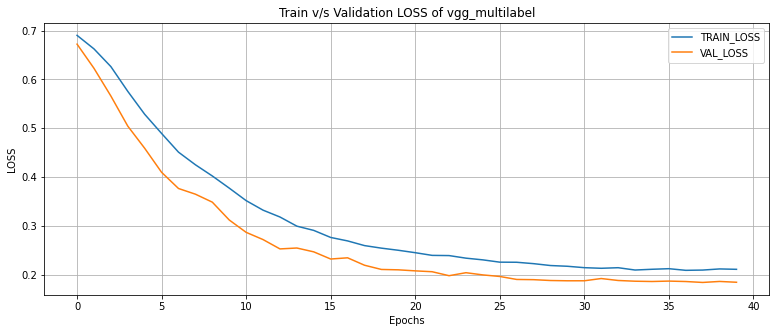

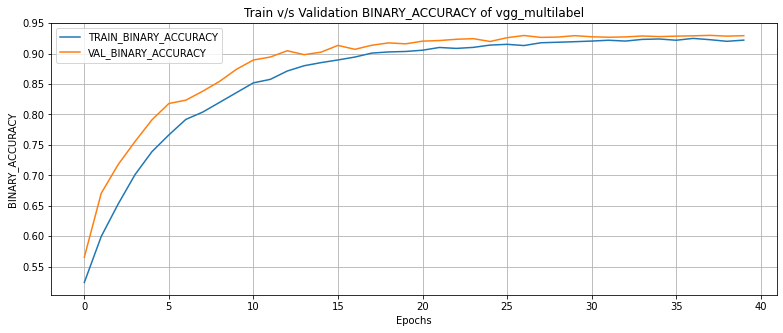

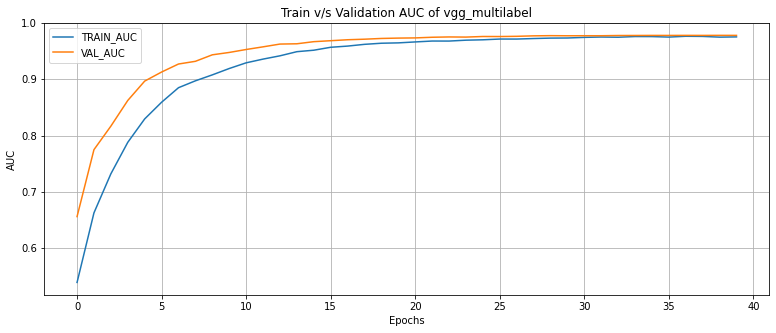

In [101]:
plot_learning_curve(multilabel_model_history.history, model_name="vgg_multilabel")

#### 2.8 Loading best model

In [89]:
best_multilabel_path = Path("./model_save/best_multilabel_model.hdf5")
if best_multilabel_path.exists():
    print(f"loading {best_multilabel_path}")
    best_multilabel_model = tf.keras.models.load_model(best_multilabel_path)

loading model_save/best_multilabel_model.hdf5


In [90]:
H,W

(450, 350)

### Inference of Multilabel Model

In [97]:
import tensorflow as tf
def inference(model, imagepath: str, thresh=0.5,):
    img = tf.keras.utils.load_img(imagepath, target_size=(H,W))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    prediction = model.predict(img_array)
    prediction = prediction[0]
    prediction = list(map(lambda x: 0 if x<thresh else 1, prediction))
    return prediction

In [111]:
image_path = "/kaggle/input/multilabel-images/images/image_8.jpg"
prediction = inference(best_multilabel_model, image_path)
prediction

[1, 1, 1, 0]

In [113]:
class_labels = ['l1','l2','l3','l4']

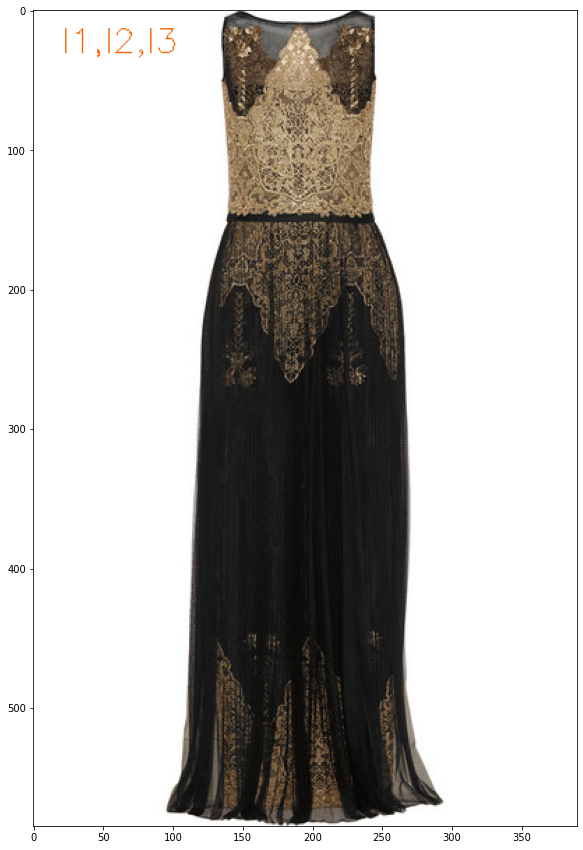

In [140]:
from PIL import Image, ImageDraw
import numpy as np
import cv2

def postprocess(image_path, prediction, class_labels, output_path=None):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # get labels
    class_labels = np.array(class_labels)
    labels = ",".join(list(class_labels[list(map(lambda x: bool(x), prediction))]))
    
    
    cv2.putText(img=img, text=labels, org=(20, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(250, 100, 0),thickness=1)
    
    plt.figure(figsize=(10,15))
    plt.imshow(img)
    if not output_path:
        plt.savefig(output_path)
        
postprocess(image_path, prediction, class_labels, output_path="./results/result.jpg")

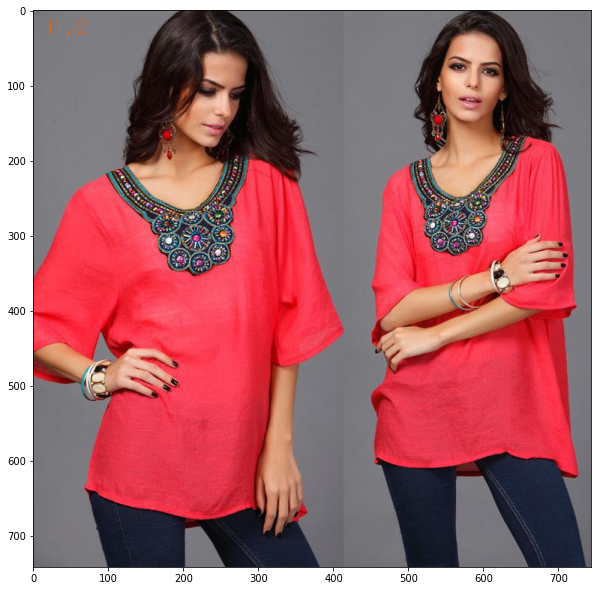

In [144]:
image_path = "/kaggle/input/multilabel-images/images/image_200.jpg"
prediction=inference(best_multilabel_model, image_path)
postprocess(image_path, prediction, class_labels, output_path="./results/result_200.jpg")

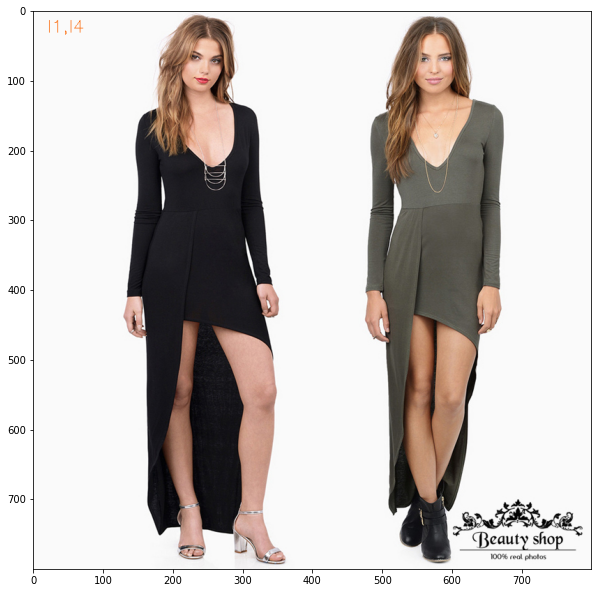

In [143]:
image_path = "/kaggle/input/multilabel-images/images/image_300.jpg"
prediction=inference(best_multilabel_model, image_path)
postprocess(image_path, prediction, class_labels, output_path="./results/result_300.jpg")

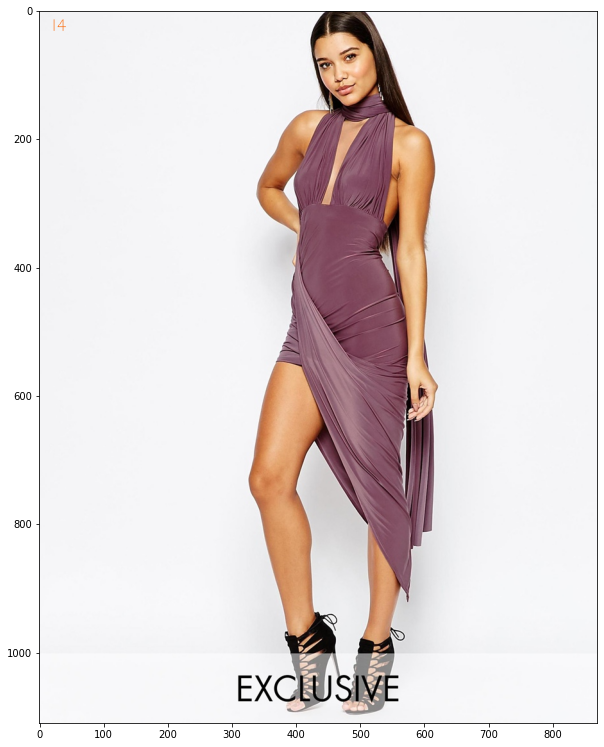

In [145]:
image_path = "/kaggle/input/multilabel-images/images/image_400.jpg"
prediction=inference(best_multilabel_model, image_path)
postprocess(image_path, prediction, class_labels, output_path="./results/result_400.jpg")

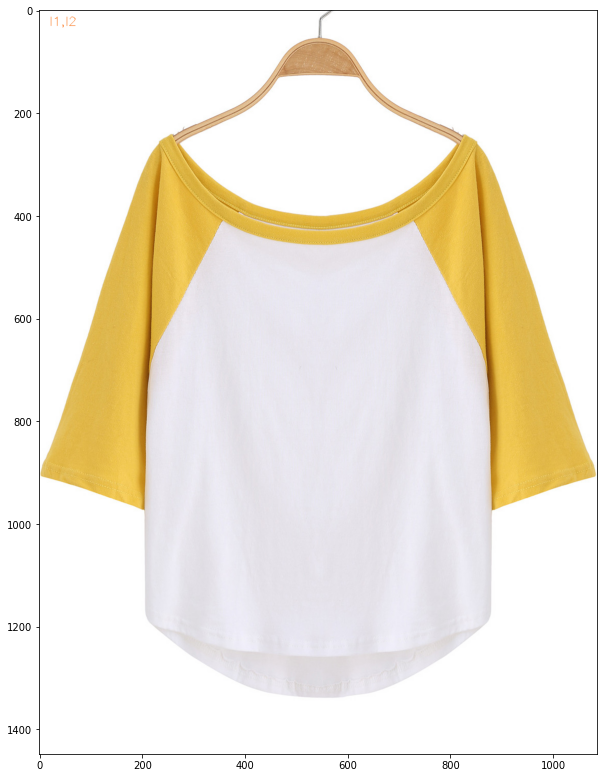

In [146]:
image_path = "/kaggle/input/multilabel-images/images/image_398.jpg"
prediction=inference(best_multilabel_model, image_path)
postprocess(image_path, prediction, class_labels, output_path="./results/result_398.jpg")